In [2]:
import os
import re
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import column
from bokeh.transform import dodge
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def get_label_from_filename(filename):
    match = re.search(r's(\d+)_', filename)
    if match:
        score = int(match.group(1))
        if 0 <= score < 140:
            return 0
        elif 140 <= score < 300:
            return 1
        elif 300 <= score < 470:
            return 2
        elif 470 <= score < 630:
            return 3
        else:
            return 4
    else:
        raise ValueError(f"Filename does not match expected pattern: {filename}")

# Custom dataset class for our images
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        for subdir, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.jpg'):
                    try:
                        self.image_files.append(os.path.join(subdir, file))
                        self.labels.append(get_label_from_filename(file))
                    except ValueError as e:
                        print(e)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def print_labels(self, num_samples=5):
        for i in range(min(num_samples, len(self.image_files))):
            print(f"Filename: {self.image_files[i]}, Label: {self.labels[i]}")


In [3]:

root_dir = './_results'  

# Create a dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((25, 105)),
    transforms.ToTensor(),
])
dataset = CustomImageDataset(root_dir=root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

dataset.print_labels(num_samples=5)

# Count the occurrences of each label
label_counts = Counter(dataset.labels)

# Print the counts for each label
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")


Filename: ./_results\gruppe0001\a11_s369_2023-06-27_09-52-42_C5_a11.jpg, Label: 2
Filename: ./_results\gruppe0001\a11_s722_2023-06-27_04-19-14_C0_a11.jpg, Label: 4
Filename: ./_results\gruppe0001\a12_s709_2023-06-27_09-31-12_C5_a12.jpg, Label: 4
Filename: ./_results\gruppe0001\a13_s704_2023-06-27_10-25-12_C50_a13.jpg, Label: 4
Filename: ./_results\gruppe0001\a13_s712_2023-06-27_09-51-53_C5_a13.jpg, Label: 4
Label 2: 225 images
Label 4: 510 images
Label 0: 7587 images
Label 3: 309 images
Label 1: 389 images


In [4]:
print(torch.cuda.is_available())

# Define the CNN model
class ChocolateCNN(nn.Module):
    def __init__(self):
        super(ChocolateCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 6 * 26, 512) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = x.view(-1, 64 * 6 * 26)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # x = self.softmax(x)
        return x

True


In [5]:

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = ChocolateCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 60
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)

    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # print(outputs)
            # print(outputs.shape)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

print("Training complete!")


cuda
Epoch 1, Train Loss: 0.3991, Validation Loss: 0.1966, Validation Accuracy: 93.18%
Epoch 2, Train Loss: 0.1990, Validation Loss: 0.1769, Validation Accuracy: 94.46%
Epoch 3, Train Loss: 0.1682, Validation Loss: 0.1948, Validation Accuracy: 93.51%
Epoch 4, Train Loss: 0.1701, Validation Loss: 0.1416, Validation Accuracy: 95.12%
Epoch 5, Train Loss: 0.1501, Validation Loss: 0.1330, Validation Accuracy: 95.01%
Epoch 6, Train Loss: 0.1411, Validation Loss: 2.6061, Validation Accuracy: 35.09%
Epoch 7, Train Loss: 0.1401, Validation Loss: 0.1449, Validation Accuracy: 95.01%
Epoch 8, Train Loss: 0.1275, Validation Loss: 0.1591, Validation Accuracy: 95.01%
Epoch 9, Train Loss: 0.1231, Validation Loss: 0.1408, Validation Accuracy: 95.01%
Epoch 10, Train Loss: 0.1138, Validation Loss: 0.1071, Validation Accuracy: 96.90%
Epoch 11, Train Loss: 0.1090, Validation Loss: 0.1224, Validation Accuracy: 95.68%
Epoch 12, Train Loss: 0.1018, Validation Loss: 0.1307, Validation Accuracy: 95.34%
Epoch 13

In [113]:
print(train_size)
print(val_size)
torch.save(model.state_dict(), 'chocolate_cnn.pth')

7216
1804


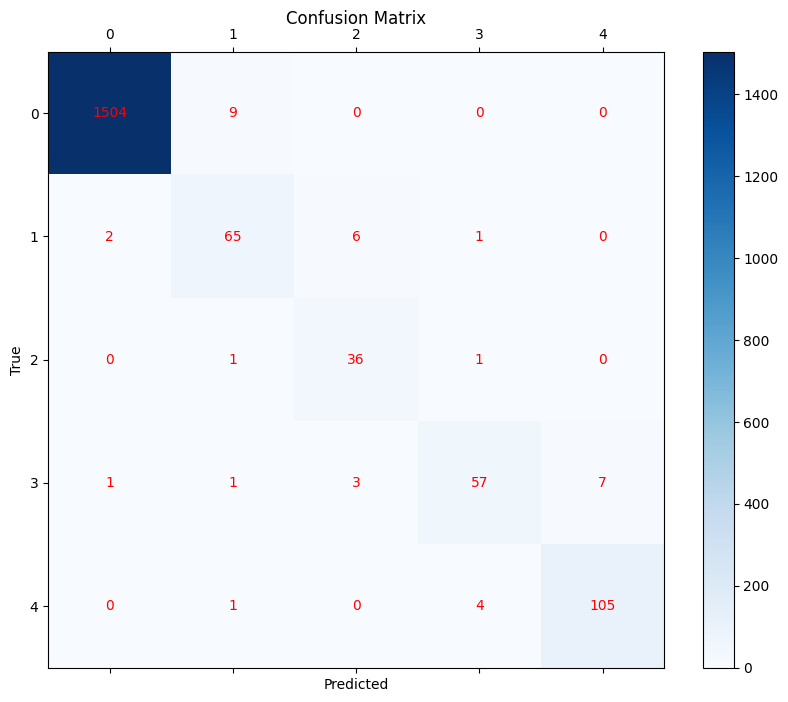

In [140]:

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Matplotlib.

    Args:
    cm (numpy.ndarray): Confusion matrix.
    class_names (list): List of class names.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', pad=20)
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))

    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    plt.xlabel('Predicted')
    plt.ylabel('True')

    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, f'{val}', ha='center', va='center', color='red')

    plt.show()

# Define class names (replace with your class names)
class_names = [0, 1, 2, 3, 4]  # or replace with ['Class 0', 'Class 1', ...]

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)

In [130]:
# Save the trained model
torch.save(model.state_dict(), 'chocolate_cnn.pth')

# Function to load the model
def load_model(model_path):
    model = ChocolateCNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

In [134]:
# Function to make predictions 
def predict_images(model, image_folder, transform, device):
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
    predictions = []
    softmax = nn.Softmax(dim=1)
    
    for img_file in image_files:
        image = Image.open(img_file).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
            # _, predicted = torch.max(output, 1)
            # predictions.append((img_file, predicted.item()))
            probabilities = softmax(output).cpu().numpy()
            predicted_class = np.argmax(probabilities, axis=1)[0]
            predictions.append((img_file, predicted_class, probabilities))
    
    return predictions

# Load the trained model
model = load_model('chocolate_cnn.pth')

# Predict images
new_image_folder = './gruppe0019'  
predictions = predict_images(model, new_image_folder, transform, device)

# Print predictions
for img_file, pred, prob in predictions[:10]:  # Print first 10 predictions
    print(f"Filename: {img_file}, Predicted Label: {pred}, Probabilities: {prob}")

Filename: ./gruppe0019\a10_s251_2023-06-27_09-53-06_C5_a10.jpg, Predicted Label: 1, Probabilities: [[4.0840567e-04 9.9959069e-01 8.6540103e-07 5.5856537e-09 6.3513084e-10]]
Filename: ./gruppe0019\a10_s50_2023-06-27_00-13-51_C0_a10.jpg, Predicted Label: 0, Probabilities: [[9.9988616e-01 8.0010257e-05 3.3819597e-05 1.3404876e-09 4.7463422e-10]]
Filename: ./gruppe0019\a10_s774_2023-06-27_04-56-10_C0_a10.jpg, Predicted Label: 4, Probabilities: [[3.6894762e-38 1.7306036e-42 1.9369923e-38 2.5630049e-13 1.0000000e+00]]
Filename: ./gruppe0019\a11_s670_2023-06-27_09-51-53_C5_a11.jpg, Predicted Label: 4, Probabilities: [[2.2420775e-44 1.4012985e-45 2.8768657e-42 3.5226314e-16 1.0000000e+00]]
Filename: ./gruppe0019\a11_s695_2023-06-27_10-25-12_C50_a11.jpg, Predicted Label: 4, Probabilities: [[1.7234026e-29 2.2865920e-34 1.7997830e-29 9.4197407e-11 1.0000000e+00]]
Filename: ./gruppe0019\a11_s804_2023-06-26_22-22-39_C50_a11.jpg, Predicted Label: 4, Probabilities: [[0.0000000e+00 0.0000000e+00 0.000